The following code contains the implementations and answers for the course of the module Numerical Methods in Finance, form the MSc Mathematics and Finance Imperial college London

QUESTION 1: OPTION PRICING UNDER TRINOMIAL MODEL AND KR PARAMETRIZATION.

In [ ]:
#IMPORT packages needed:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import time  #To compute the execution time of the algorithms

#This package allows for interactive plots
from ipywidgets import interact

In [ ]:
def GetTrinomialKamradRitchken(r, dt, sigma, l):
    u = np.exp(l*sigma * np.sqrt(dt))
    d= 1/u
    R = np.exp(r * dt) #Discount factor at each period jump
    aux = (r-sigma**2 /2)*np.sqrt(dt) /(2*l*sigma)
    qu = 1/(2*l**2) + aux
    qd = 1/(2*l**2) - aux
    qm = 1 - 1/(l**2)
    return u, d, qu, qm, qd, R


def TrinomialTree(s0, sigma, lmda, r, N, T, payoff, american = False):
    """
    s0 initial price
    sigma volatility
    lmda auxiliary variable of KR
    r interest rate
    N number of periods
    T time to maturity
    payoff option payoff function as a function of the stock price
    american = True for American options, False by default
    """
    # Set up parameters
    u, d, qu, qm, qd, R = GetTrinomialKamradRitchken(r, T/N, sigma, lmda)
    
    #Set up the matrices to store the values of the processes
    S=np.zeros((2*N+1,N+1)) #Stock price process
    V=np.zeros((2*N+1,N+1)) #Option price process

    for t in range(N+1):
        S[0:2*t+1,t]= s0 * (u**t) * (d**np.arange(0,2*t+1)) #Cover all possible values of S_t

    #Calculate the payoff at terminal time for all possible final values of S_T
    V[:,N] = payoff(S[:,N])
    
    #Loop backwards in time
    for t in reversed(range(N)):
      if american:
        V[0:2*t+1, t] = np.maximum( payoff(S[0:2*t+1, t]), (qu * V[0:2*t+1,t+1] + qm * V[1:2*t+2, t+1] + qd * V[2:2*t+3, t+1]) / R)  
      else:
        V[0:2*t+1,t]=(qu * V[0:2*t+1,t+1] + qm * V[1:2*t+2,t+1] + qd * V[2:2*t+3,t+1]) / R 
        
    #return V, S   #Return tree of both stock and asset price
    return V[0,0] #Only return the initial value

We also define the function for the prices under the Black-Scholes model for the call to compare.

In [ ]:
#Exact Black Scholes pric
def CallBlackScholes(s, r, sigma, t, k):
    d1=(np.log(s/k) + (r + sigma**2 / 2) * t) / ( sigma * np.sqrt(t))
    d2= d1 - np.sqrt(t) * sigma
    return s * stats.norm.cdf(d1) - k * np.exp(-r*t) * stats.norm.cdf(d2)

#The payoff functions take a strike and return a function that takes parameter price
def CallPayoff(K):
  # The payoff function to be used: g(s)=max(s-K, 0)
  return lambda x : np.maximum(x - K, 0)

def PutPayoff(K):
  # The payoff function to be used: g(s)=max(K-s, 0)
  return lambda x : np.maximum(K - x, 0)

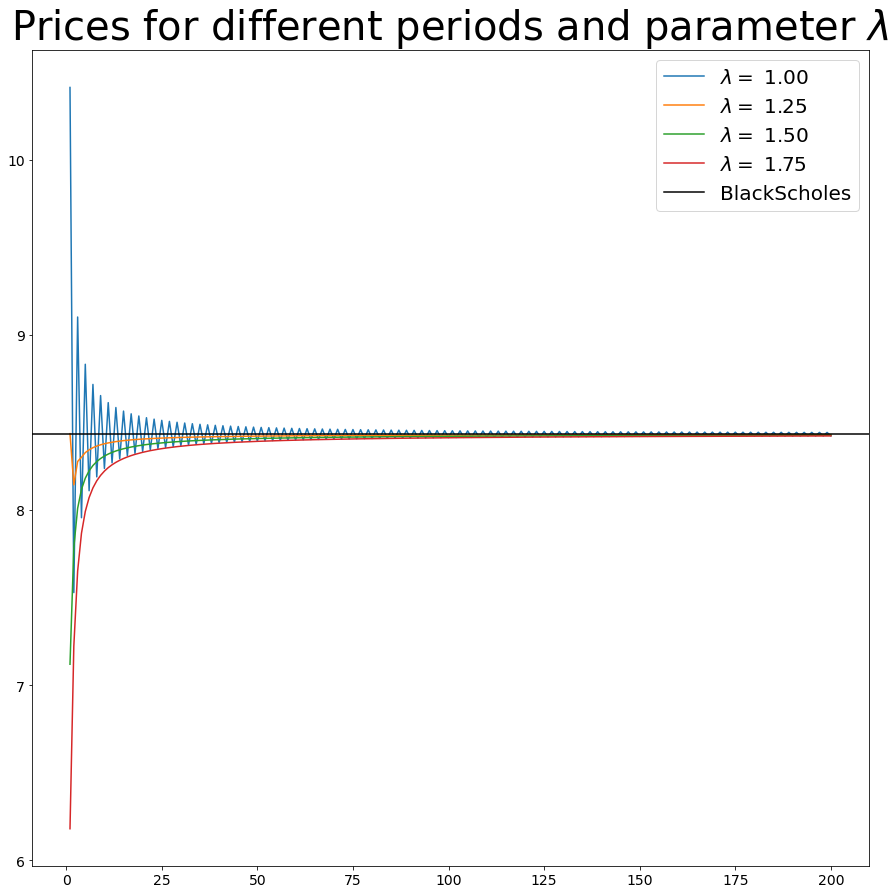

In [ ]:
s0, r, T, sigma, K, L = 100, 0.01, 1, 0.2, 100, [1,1.25,1.5,1.75]     # Option and market parameters                                  
n_min ,n_max , step_size = 1, 200, 1

xx = np.arange(n_min ,n_max+1 , step_size)
plt.figure(figsize=(15,15))
for l in L:
  yy = [TrinomialTree(s0, sigma, l, r, x, T, CallPayoff(K), american = False) for x in xx]
  plt.plot(xx, yy, label='$\lambda=$ %.2f' %l)

#Theoretical Black-Scholes price:
plt.axhline(y = CallBlackScholes(s0, r, sigma, T, K), label="BlackScholes", color="black", linestyle='-')
      
plt.title("Prices for different periods and parameter $\lambda$", fontsize=40)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
@interact(s0 = (50,180,10))
def call_plots(s0 = 110):

    r, T, sigma, K, L = 0.01, 1, 0.2, 100, [1,1.25,1.5,1.75]
    N = 200

    option_price_df=pd.DataFrame(np.zeros((N,4)))
    option_price=np.zeros(N)
    for i,l in enumerate(L):
        for n in range(1,N+1):
            option_price[n-1] = TrinomialTree(s0, sigma, l, r, n, T, CallPayoff(K), american = False)
        option_price_df[i]=option_price

    option_price_df.columns = ["Lambda=%.2f"%f for f in L]
    plt.figure()
    plt.rcParams.update({'font.size':10})
    ax = option_price_df.plot(figsize=(8,8), ylabel = "Price", xlabel = "Number of periods, N")

    ax.axhline(CallBlackScholes(s0, r, sigma, T, K),label="BlackScholes",color="black",lw=2)
    ax.legend(fontsize=8)
    ax.set_title("Plot of European Call Option Prices using trinomial model, S0: %.2f" %s0)
    return ax

interactive(children=(IntSlider(value=110, description='s0', max=180, min=50, step=10), Output()), _dom_classe…

In [ ]:
start_time = time.time()
N=500
K=100
s0=np.arange(60,180,10)
M=len(s0)
lmda_vec=[1,1.25,1.5,1.75]
sigma=0.2
T=1
r=0.01

option_price_df_s0=pd.DataFrame(np.zeros((M,4))) #table of trinomial values
option_price=np.zeros(M)

for i,l in enumerate(lmda_vec):
    #update for lambda
    for m in range(0,M):
        #update for new value of S0 at each step
        v=TrinomialTree(s0[m], sigma, l, r, 500, T, CallPayoff(K), american = False)
        option_price[m]=v-CallBlackScholes(s0[m],r,sigma,T,K)
    option_price_df_s0[i]=option_price

option_price_df_s0.columns=['$\lambda$ =%.2f'  %f for f in lmda_vec]
option_price_df_s0.index=[i for i in s0]
option_price_df_s0.index.name="S0"

end_time = time.time()
time_elapsed = end_time - start_time
print("Time taken: {:.6f} seconds".format(time_elapsed))
option_price_df_s0

Time taken: 1.207961 seconds


,$\lambda$ =1.00,$\lambda$ =1.25,$\lambda$ =1.50,$\lambda$ =1.75
S0,,,,
60,-0.000170,-0.000164,-0.000157,0.000063
70,-0.001211,-0.000595,0.000036,0.000038
80,0.001067,-0.000974,0.000506,0.000257
90,-0.001083,0.001322,-0.000349,0.000592
100,-0.003972,-0.001136,-0.002492,-0.004095
110,0.002474,0.001615,-0.000864,-0.001966
120,-0.000100,0.000526,0.000999,0.001022
130,0.000462,0.000182,0.000497,0.000189
140,-0.000660,-0.000705,-0.000686,0.000531


In [ ]:
start_time = time.time()
S0 = np.arange(60, 181, 5)
r, T, sigma, K, L =  0.01, 1, 0.2, 100, [1,1.25,1.5,1.75]     # Option and market parameters 
N = 500                                        # Number of periods

xx = [[TrinomialTree(s0, sigma, l, r, N, T, CallPayoff(K), american = False) - CallBlackScholes(s0, r, sigma, T, K)
       for l in L] for s0 in S0]
df = pd.DataFrame(xx)
df.columns = ["Lambda = %.2f" %l for l in L]

Initial_price = pd.Series([s0 for s0 in S0])
df.index = Initial_price
df.index.name = 'Inital Price S0:'

end_time = time.time()
time_elapsed = end_time - start_time
print("Time taken: {:.6f} seconds".format(time_elapsed))

df.head(15) 

Time taken: 2.217493 seconds


,Lambda = 1.00,Lambda = 1.25,Lambda = 1.50,Lambda = 1.75
Inital Price S0:,,,,
60,-0.000170,-0.000164,-0.000157,0.000063
65,-0.000716,-0.000234,-0.000285,0.000190
70,-0.001211,-0.000595,0.000036,0.000038
75,-0.001518,-0.000256,0.000259,0.000543
80,0.001067,-0.000974,0.000506,0.000257
85,-0.001750,0.000852,-0.000755,0.001120
90,-0.001083,0.001322,-0.000349,0.000592
95,-0.000426,0.001688,0.000053,0.000705
100,-0.003972,-0.001136,-0.002492,-0.004095


In [ ]:
print(np.sqrt((df**2).mean(axis=0)))

Lambda = 1.00    0.001271
Lambda = 1.25    0.000843
Lambda = 1.50    0.000764
Lambda = 1.75    0.001122
dtype: float64


We choose λ = 1.50 as optimal choice for the free parameter given that it minises the squared error.

#Question 1 part B: American Options

In [ ]:
xx, r, T, sigma, K, l = np.linspace(70, 160, 150), 0.01, 1, 0.2, 100, 1.5     # Option and market parameters     
N = 500                               

yy = pd.Series([TrinomialTree(x, sigma, l, r, N, T, CallPayoff(K), True) for x in xx])
zz = pd.Series([CallPayoff(K)(x) for x in xx])
df = pd.concat([yy, zz], axis = 1)
df.columns = ['American Call Price', 'Intrinsic value']

Initial_price = pd.Series(xx)
df.index = Initial_price
df.index.name = 'Inital Price S0:'

In [ ]:
df

,American Call Price,Intrinsic value
Inital Price S0:,,
70.000000,0.279557,0.000000
70.604027,0.311216,0.000000
71.208054,0.347019,0.000000
71.812081,0.385388,0.000000
72.416107,0.426230,0.000000
...,...,...
157.583893,58.663530,57.583893
158.187919,59.263119,58.187919
158.791946,59.863009,58.791946


Text(0.5, 1.0, 'American Call Option Price vs Intrinsic Value')

<Figure size 432x288 with 0 Axes>

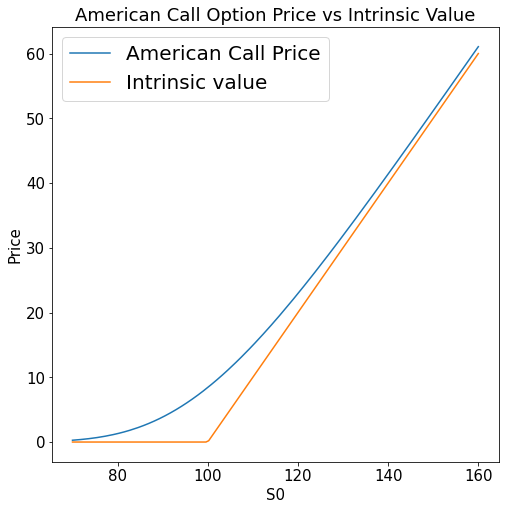

In [ ]:
plt.figure()
plt.rcParams.update({'font.size':15})
df.plot(xlabel="S0",ylabel="Price",figsize=(8,8))
plt.legend(fontsize=20)
plt.title("American Call Option Price vs Intrinsic Value")

In [ ]:
xx, r, T, sigma, K, l = np.linspace(60, 160, 150), 0.01, 1, 0.2, 100, 1.5     # Option and market parameters     
N = 500                               

yy = pd.Series([TrinomialTree(x, sigma, l, r, N, T, PutPayoff(K), True) for x in xx])
zz = pd.Series([PutPayoff(K)(x) for x in xx])
df = pd.concat([yy, zz], axis = 1)
df.columns = ['American Put Price', 'Intrinsic value']
df['Intrinsic - Put Price'] = df['American Put Price'] - df['Intrinsic value']

Initial_price = pd.Series(xx)
df.index = Initial_price
df.index.name = 'Inital Price S0:'

We wil observe that with initial price under 70 the intrinsic and continuation value are equal:

In [ ]:
#Check when early exercise is viable
df[df['Intrinsic - Put Price'] <= 0]

,American Put Price,Intrinsic value,Intrinsic - Put Price
Inital Price S0:,,,
60.000000,40.000000,40.000000,0.0
60.671141,39.328859,39.328859,0.0
61.342282,38.657718,38.657718,0.0
62.013423,37.986577,37.986577,0.0
62.684564,37.315436,37.315436,0.0
63.355705,36.644295,36.644295,0.0
64.026846,35.973154,35.973154,0.0
64.697987,35.302013,35.302013,0.0
65.369128,34.630872,34.630872,0.0


Text(0.5, 1.0, 'American Put Option Price vs Intrinsic Value')

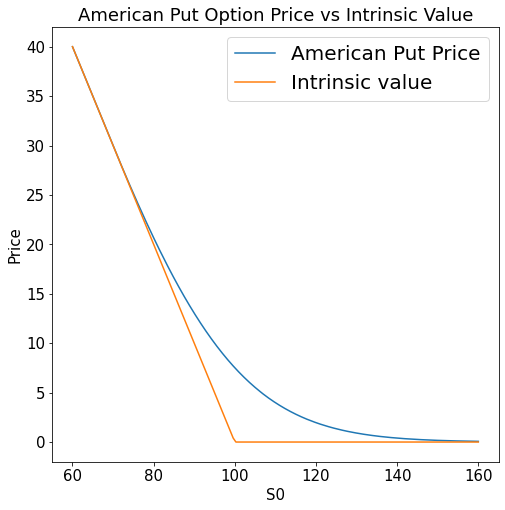

In [ ]:
plt.figure()
plt.rcParams.update({'font.size':15})
df['American Put Price'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
df['Intrinsic value'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
plt.legend(fontsize=20)
plt.title("American Put Option Price vs Intrinsic Value")

It may be optimal to exercise early when the initial asset price is at or close to 0, if the underlying prices reaches 0 it will never recover, in that case the payoff essentially becomes the constant strike price $K$. Clearly it is not optimal to exercise early when the asset price is above the strike, this can also be seen in the graph by the fact that the intrinsic value sits below put value, in other the continuation value is higher. But when is closer to 70 and lower, it becomes optimal to exercise early. It should be noted that this is not a graph of the continuation value but the put value, which will be the maximum between the intrinsic value and continuation value. So when the 2 lines cross over it here it becomes optimal to exercise early. 

When the option begins deep in the money it may be optimal to exercise early, though such an options price will approach the intrinsic value anyway, in a real world scenario invloving transaction costs and bid-ask spreads it may not be optimal to immediately exercise

Now we compare different values of volatilities.\
Please note that it make take around 5 seconds to change the graph.

In [ ]:
@interact(sigma = (0.1,0.8,0.1))
def sigmaplots(sigma=0.2):
    xx, r, T, K, l = np.linspace(60, 160, 150), 0.01, 1, 100, 1.5     # Option and market parameters     
    N = 500                               

    yy = pd.Series([TrinomialTree(x, sigma, l, r, N, T, PutPayoff(K), True) for x in xx])
    zz = pd.Series([PutPayoff(K)(x) for x in xx])
    df = pd.concat([yy, zz], axis = 1)
    df.columns = ['American Put Price', 'Intrinsic value']
    df['Intrinsic - Put Price'] = df['American Put Price'] - df['Intrinsic value']

    Initial_price = pd.Series(xx)
    df.index = Initial_price
    df.index.name = 'Inital Price S0:'
    
    plt.figure()
    plt.rcParams.update({'font.size':20})
    df['American Put Price'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    df['Intrinsic value'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    plt.legend(fontsize=20)
    plt.title("American Put Option vs Intrinsic Value $\sigma=%.2f$"%sigma)

    plt.show()
    #If want to see the prices for which they have the same values
    #print('Under a volatility of %.2f the intrinsic - continuation value is 0 for the following s0:' %sigma)
    #print(df[df['Intrinsic - continuation'] <= 0]['Continuation value'])

interactive(children=(FloatSlider(value=0.2, description='sigma', max=0.8, min=0.1), Output()), _dom_classes=(…

As the volatility increases the value of the american put increases above the intrinsic value. This is because the greater the volatility the more likely it is at any point for the asset price to drop below the strike, or reach the optimal exercise boundary. So at each discrete time point the continuation value is higher as there is greater potential for it to change and fall further below the strike the longer we wait.

When the volatility decreases we see that the price gets closer to the intrinsic value. By decreasing the volatility the asset will deviate less from its initial value throughout the options life, and so more closely resembles the intrinsic value. As  𝜎  gets closer and closer to 0 the asset essentially becomes constant so the value of the american put option becomes the intrinsic value.

In [ ]:
@interact(r = (0.01,0.1,0.01))
def rplots(r = 0.01):
    xx, sigma, T, K, l = np.linspace(60, 160, 150), 0.2, 1, 100, 1.5     # Option and market parameters     
    N = 500                               

    yy = pd.Series([TrinomialTree(x, sigma, l, r, N, T, PutPayoff(K), True) for x in xx])
    zz = pd.Series([PutPayoff(K)(x) for x in xx])
    df = pd.concat([yy, zz], axis = 1)
    df.columns = ['American Put Price', 'Intrinsic value']
    df['Intrinsic - Put Price'] = df['American Put Price'] - df['Intrinsic value']

    Initial_price = pd.Series(xx)
    df.index = Initial_price
    df.index.name = 'Inital Price S0:'
    
    plt.figure()
    plt.rcParams.update({'font.size':20})
    df['American Put Price'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    df['Intrinsic value'].plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    plt.legend(fontsize=20)
    plt.title("American Put Option vs Intrinsic Value r=%.2f"%r)

    plt.show()
    #If want to see the prices for which they have the same values
    #print('Under interest rate of %.2f the intrinsic - continuation value is 0 for the following s0:' %r)
    #print(df[df['Intrinsic - continuation'] <= 0]['Continuation value'])

interactive(children=(FloatSlider(value=0.01, description='r', max=0.1, min=0.01, step=0.01), Output()), _dom_…

By increasing the interest rate  𝑟  the value of the american put decreases and becomes closer to the intrinsic value, particularly when it starts in the money. This is because by increasing the interest rate, we discount the future values at a higher rate, so they have a much smaller present value. In other words with higher interest rates the sooner we can exercise the better to avoid the decaying value over time.

# Q1 (c)
## Lookback option
We price a floating strike lookback put option:
$$\sup\limits_{0\leq u\leq T}(S_u - S_T)$$ 
We can also define it as an American option:
$$\sup\limits_{0\leq u\leq T}(S_u - S_\tau)$$
where $\tau$ is a stopping time.

In [ ]:
def Lookback_option(s0, sigma, lmda, r, N, T, american = False):
    """
    s0 initial price
    sigma volatility
    lmda auxiliary variable of KR
    r interest rate
    N number of periods
    T time to maturity
    american = True for American options, False by default
    """
    # Set up parameters
    u, d, qu, qm, qd, R = GetTrinomialKamradRitchken(r, T/N, sigma, lmda)

    #Create arrays to store the variables:
    S=np.zeros((2 * N+1, N+1))     #Stock price process    
    #set up S[k,n]=s0*u^(n-k) = s0*u^n*d^k for 0<=k<=2n
    for t in range(N+1):
        S[0:2*t+1,t] = (s0 * u**t) * (d**(np.arange(0,2 * t+1)))
    
    #Set up grid for auxiliary function m_j^n
    M = np.zeros((N+1, N+1))
    for t in range(N+1):
        M[0:t+1,t]=s0 * u**np.arange(t,-1,-1)
    
    """
    Option price process 
    N+1 arrays of size 2*Nx2*N
    To cover all combinations of the auxiliary process and the stock price
    """
    V=np.zeros((N+1, N+1, 2 * N+1))

    #Apply payoff at terminal time
    #note the index is reversed from the lecture notes
    for k in range(2 * N+1):
        jmax = min(k,N)
        for j in range(0,jmax + 1):
           V[N, j, k] = M[j, N] - S[k, N]

    phi= lambda k, j: min(k, j+1) #shooting operator

    # now iterate back through the tree
    for n in reversed(range(N)):
      for k in range(2 * n+1):
          jmax = min(k, n)
          for j in range(jmax+1):
            if american:
              V[n,j,k]=np.maximum(M[j,n]-S[k,n],(qu*V[n+1,phi(k,j),k]+qm*V[n+1,phi(k+1,j),k+1]+qd*V[n+1,phi(k+2,j),k+2])/R)
            else:
              V[n,j,k]= (qu*V[n+1,phi(k,j),k]+qm*V[n+1,phi(k+1,j),k+1]+qd*V[n+1,phi(k+2,j),k+2])/R
    
    return V[0,0,0] # return only the initial value

In [ ]:
s0, r, T, sigma, K, lmda = 100, 0.01, 1, 0.2, 100, 1.5     # Option and market parameters     

N_vec= 100 * np.arange(1,6)
american_lookback = np.zeros(5)
euro_lookback = np.zeros(5)
times = np.zeros((5,2))

for i,N in enumerate(N_vec):
    #time the european lookback
    t0=time.time()
    euro_lookback[i]=Lookback_option(s0, sigma, lmda, r, N, T, False)
    dt=time.time()-t0
    times[i,0]=dt
    
    #time the american lookback
    t0=time.time()
    american_lookback[i] = Lookback_option(s0, sigma, lmda, r, N, T, True)
    dt=time.time()-t0
    times[i,1]=dt
    
lookback_df=pd.DataFrame([euro_lookback,times[:,0], american_lookback,times[:,1]],
                          columns = ["N=%i"%i for i in N_vec], 
                          index = ["European Option","European time","American Option","American Time"]
                        )

In [ ]:
lookback_df

,N=100,N=200,N=300,N=400,N=500
European Option,14.750883,15.218390,15.430247,15.557935,15.645676
European time,1.241969,8.304744,28.224109,65.934902,133.397734
American Option,14.883068,15.350834,15.562853,15.690664,15.778485
American Time,2.443912,17.523430,61.034037,139.966614,271.194328


Text(0.5, 1.0, 'Plot of computation time against number of periods (Log-Log-Scale)')

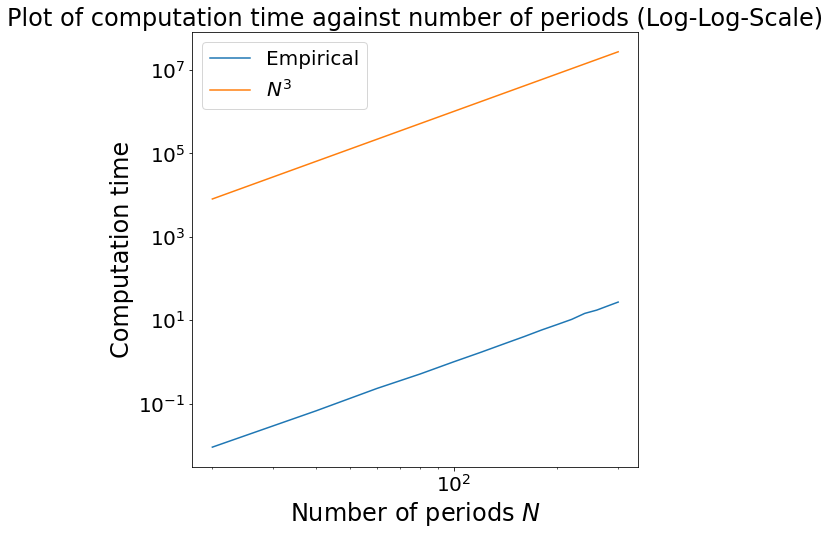

In [ ]:
#Calculate computation times empirically
s0, r, T, sigma, K, lmda = 100, 0.01, 1, 0.2, 100, 1.5     # Option and market parameters     


N_vec = np.arange(20,320,20)
time_vec=np.zeros(len(N_vec))

for i,N in enumerate(N_vec):
    t0=time.time()
    Lookback_option(s0, sigma, lmda, r, N, T)
    dt=time.time()-t0
    time_vec[i]=dt

plt.figure(figsize=(8,8))
plt.loglog(N_vec,time_vec,label="Empirical")
plt.loglog(N_vec,N_vec**3,label="$N^3$")
plt.legend(fontsize=20)
plt.xlabel("Number of periods $N$",fontsize='large')
plt.ylabel("Computation time",fontsize='large')
plt.title("Plot of computation time against number of periods (Log-Log-Scale)")

Since this is a path dependent option how fine our lattice or grid is has a significant impact on the accuracy of prices. This is because between any two discretised points of the asset trajectory the asset can take on values that won't be captured. Small movements like these can change the historical maximum of the stock, particularly if we are quite close to the maximum already. To this end since we are working over the time frame of 1 year, within a single day it is entirely possible for the asset to reach a new maximum at some point and fall below the previous maximum again by the end of the day. Depending on the number of points we observe the number of grid points corresponding to a single day we could easily miss these changes, leading to slight inaccuracies.

In order to obtain reliable prices it is likely necessary to use $N$ close to 1000, which would correspond to just under 4 points a day (for 252 trading days in 1 year). However at 500 points the computation is already quite slow. We can see from the plot of the computation times that it scales similarly to a rate of $O(N^3)$. In this sense the computation time scales far too quickly with the number of periods

In [ ]:
#Theoretical Price under BS:
def FloatLookBackPut(s0,r,sigma,T):
  
    d1=1/(sigma*np.sqrt(T))*(np.log(1)+(r+1/2*sigma**2)*T)
    d2=1/(sigma*np.sqrt(T))*(np.log(1)+(r-1/2*sigma**2)*T)
    
    return (1+sigma**2/(2*r))*s0*stats.norm.cdf(d1)+np.exp(-r*T)*s0*stats.norm.cdf(-d2)-sigma**2/(2*r)*np.exp(-r*T)*s0*stats.norm.cdf(-d2)-s0

In [ ]:
s0, r, T, sigma, K, lmda = 100, 0.01, 1, 0.2, 100, 1.5     # Option and market parameters     
N = 500

print("The price under BS is: %.5f" %FloatLookBackPut(100, 0.01, 0.2, 1))
print("The numerical estimate is: %.5f" %Lookback_option(s0, sigma, lmda, r, N, T))

The price under BS is: 16.40877
The numerical estimate is: 15.64568
